In [5]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# evironmeant setting


In [6]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [7]:
torch.cuda.is_available()

True

In [8]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
x_in = torch.Tensor(X_train.values)
#y_in = torch.Tensor(y_train.values)
x_val = torch.Tensor(X_test.values)



In [10]:
#scaling y
scaler = RobustScaler()
y_in_s = torch.Tensor(scaler.fit_transform(y_train.values.reshape(-1,1)))
y_val_s = torch.Tensor(scaler.transform(y_test.values.reshape(-1,1)))

y_in = torch.Tensor(y_train.values)
y_val = torch.Tensor(y_test.values)
#inverse_transform(X)

In [11]:
#Xavier initialization
def init_weights(m,k=1,gain = 100):
    for i in m:
        if isinstance(i, nn.Linear):
            w = torch.empty(i.in_features, i.out_features)
            torch.nn.init.xavier_normal(i.weight, gain = gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Best Model: 11 hidden  with RELU act

### 1. Change into LG UA

In [13]:
models_LG_UA = []

In [14]:

N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_LG_UA = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_LG_UA,0.1,1)
model_LG_UA(x_in)

C:\Users\IanKu\AppData\Local\Temp\ipykernel_17684\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


tensor([[ 3.1570e-01],
        [ 3.3765e-01],
        [ 2.7650e-01],
        [ 2.1201e-01],
        [ 3.0292e-01],
        [ 1.2991e-01],
        [ 4.1571e-01],
        [ 1.4668e-01],
        [ 7.0292e-02],
        [ 2.3641e+00],
        [ 2.4054e-01],
        [ 2.5389e-01],
        [ 1.8336e-01],
        [ 2.3096e-01],
        [ 1.9560e-01],
        [ 7.9901e-01],
        [ 3.0197e-01],
        [ 1.6718e-01],
        [ 1.8270e-01],
        [ 1.7053e-01],
        [ 2.4270e-01],
        [ 2.7646e-01],
        [ 2.9265e-03],
        [ 2.3174e-01],
        [ 4.0028e-01],
        [-1.7534e-02],
        [ 2.9207e-01],
        [ 9.3891e-01],
        [ 2.4347e-01],
        [ 1.3266e+00],
        [ 1.3891e-01],
        [ 3.0437e-01],
        [-4.1900e-01],
        [ 2.6513e-01],
        [ 2.0236e-01],
        [ 1.6650e-01],
        [ 2.4120e-01],
        [-2.1417e-01],
        [ 1.5687e-01],
        [ 1.3711e-01],
        [ 1.7467e-01],
        [ 1.5872e-01],
        [-3.4479e-01],
        [ 2

In [15]:

l_r = 1e-3
optimizer = torch.optim.Adam(model_LG_UA.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)
epoch = 0
loss_in_list = []
loss_out_list = []

while True:
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_LG_UA(x_in)
    loss_in = nn.functional.mse_loss(y_pred,y_in_s)

    y_pred_val = model_LG_UA(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val,y_val_s)
    l2 = l2_loss(model_LG_UA)

    loss_out +=l2
    loss_in+=l2
    print(loss_in.item(),loss_out.item())
    loss_in_list .append(loss_in.item())
    loss_out_list .append(loss_out.item())


    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()

    if loss_in < 0.05: break
    lr_scheduler.step()
    epoch +=1

models_LG_UA.append([model_LG_UA,loss_in ])
print(epoch )


11.945233345031738 35.48158645629883
9.607461929321289 34.632808685302734
4.128406047821045 13.044880867004395
1.5296237468719482 2.398475408554077
3.5896155834198 11.25457763671875
3.354741096496582 10.388690948486328
1.6186342239379883 3.215545654296875
1.33537757396698 2.002528190612793
2.328197956085205 6.165585041046143
2.519395112991333 7.295804023742676
1.7253351211547852 4.059452533721924
1.0386250019073486 1.3993370532989502
1.1846572160720825 2.126357078552246
1.6369001865386963 4.048408508300781
1.542698860168457 3.691209316253662
1.0806567668914795 1.809580683708191
0.9263699054718018 1.2405781745910645
1.1336157321929932 2.2095537185668945
1.269885778427124 2.8142926692962646
1.101435661315918 2.108147144317627
0.8669273257255554 1.1796163320541382
0.8623493909835815 1.271121621131897
1.0042393207550049 1.9909286499023438
1.0095176696777344 2.1018097400665283
0.829755425453186 1.3402001857757568
0.7575865983963013 1.001468539237976
0.8458399772644043 1.3796037435531616
0.8

ValueError: x and y must have same first dimension, but have shapes (304,) and (11806,)

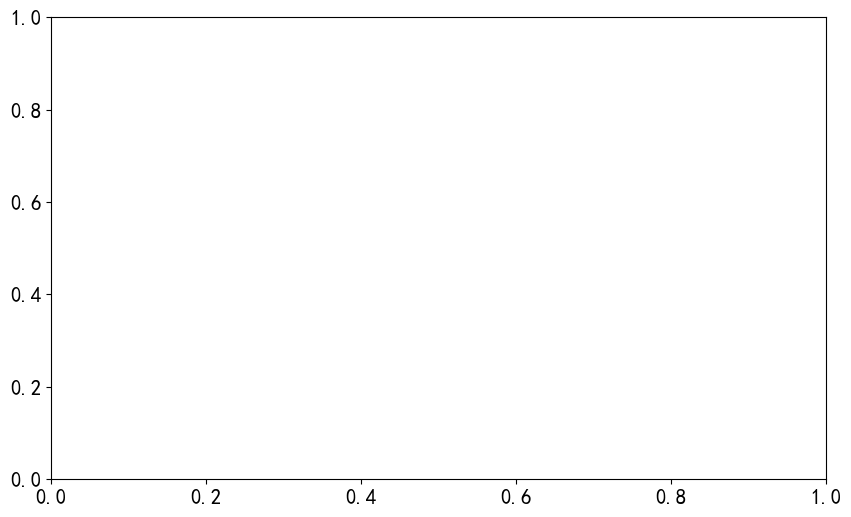

In [18]:
import matplotlib.pyplot as plt

# Assuming you have the epoch numbers as a list
epoch = list(range(1, epoch))

# Assuming you have the lists for loss_in and loss_out
loss_in_list
loss_out_list

plt.figure(figsize=(10, 6))
plt.plot(epoch, loss_in_list, label='Loss In')
plt.plot(epoch, loss_out_list, label='Loss Out')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
y_pred_val_s = model_LG_UA(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(loss1 )


y_pred_val = torch.Tensor(scaler.inverse_transform(y_pred_val_s.detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,y_val)
print(loss2)

tensor(0.1923, grad_fn=<MseLossBackward0>)
tensor(1.2845e+10)


C:\Users\IanKu\AppData\Local\Temp\ipykernel_19756\1216723949.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,y_val)


In [22]:
random.seed ( 10 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[132198.765625, 145000.0],
 [186423.71875, 183500.0],
 [129047.015625, 126000.0],
 [175076.375, 176000.0],
 [154304.109375, 175000.0],
 [145279.0, 146000.0],
 [177650.921875, 156500.0],
 [190752.265625, 195400.0],
 [123554.1171875, 128500.0],
 [155157.796875, 160000.0],
 [211608.171875, 270000.0],
 [168169.5, 178000.0],
 [154792.359375, 146000.0],
 [308590.0625, 423000.0],
 [111482.21875, 113000.0],
 [133992.796875, 135000.0],
 [160580.890625, 153500.0],
 [167142.484375, 192140.0],
 [306658.4375, 276000.0],
 [316508.84375, 310000.0],
 [97406.296875, 79500.0],
 [240158.375, 168000.0],
 [252409.90625, 255000.0],
 [169030.640625, 173500.0],
 [272276.46875, 262500.0],
 [205238.546875, 215200.0],
 [119939.390625, 134000.0],
 [214848.0, 217000.0],
 [114310.828125, 55993.0],
 [165314.125, 225000.0],
 [133234.015625, 123000.0],
 [168965.3125, 175000.0],
 [372149.875, 310000.0],
 [60961.6015625, 35311.0],
 [124069.6796875, 135000.0],
 [189583.109375, 155835.0],
 [373147.0, 380000.0],
 [132891.

### 2. Change into LG EB UA

In [23]:

N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_11 = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_11,0.1,1)
model_11(x_in)


C:\Users\IanKu\AppData\Local\Temp\ipykernel_19756\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


tensor([[-4.8479e-01],
        [-1.5683e-01],
        [-2.6248e-05],
        [-6.1402e-01],
        [-3.9736e+00],
        [-6.8782e-01],
        [-6.0141e+00],
        [ 1.2391e-01],
        [-4.3362e-02],
        [-1.3139e+01],
        [ 3.8604e-01],
        [ 1.8859e-01],
        [-6.0879e-01],
        [-3.5070e-02],
        [-2.7486e-01],
        [-1.1308e+01],
        [-6.3636e-01],
        [ 1.6923e-01],
        [ 3.8673e-01],
        [-4.0347e-01],
        [-6.2324e-01],
        [-3.0473e+00],
        [-1.4760e-01],
        [-4.0477e-01],
        [-5.4049e+00],
        [-1.0441e+00],
        [ 1.5313e-01],
        [-1.4044e+01],
        [ 4.7344e-02],
        [-4.6656e+01],
        [ 1.8486e-01],
        [ 2.8889e-01],
        [-4.2505e+00],
        [-6.6347e-02],
        [ 7.6983e-02],
        [-4.0170e-02],
        [-8.0818e-02],
        [-3.6257e+00],
        [ 9.6579e-02],
        [-7.3003e-01],
        [-1.7946e-01],
        [-4.4921e-01],
        [-3.9280e+00],
        [-3

In [24]:
models_LG_EB = []

In [25]:
epochs = 3000
l_r = 1e-3
optimizer = torch.optim.Adam(model_11.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)

for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_11(x_in)
    loss_in = nn.functional.mse_loss(y_pred,y_in_s)

    y_pred_val = model_11(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val,y_val_s)
    l2 = l2_loss(model_11)

    loss_out +=l2
    loss_in+=l2
    print(loss_in.item(),loss_out.item())


    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()

    if loss_in < 0.1: break
    lr_scheduler.step()


models_LG_EB.append([model_11,loss_in ])

78.8706283569336 138.40835571289062
25.069019317626953 82.89295196533203
30.351665496826172 99.94844818115234
22.320262908935547 63.010093688964844
11.29625129699707 23.249723434448242
6.0806732177734375 7.757354736328125
4.757946014404297 7.356480121612549
5.005533695220947 12.092121124267578
5.482476234436035 16.78774070739746
5.343287467956543 17.992189407348633
4.51363468170166 15.293111801147461
3.7070529460906982 11.974489212036133
2.782384157180786 8.05572509765625
1.9865591526031494 4.373662948608398
1.5644961595535278 2.1943483352661133
1.5850989818572998 1.9800543785095215
1.8911397457122803 2.992117166519165
2.2063608169555664 4.177702903747559
2.336974859237671 4.7880167961120605
2.2588303089141846 4.7107648849487305
2.015908718109131 3.9670798778533936
1.673964262008667 2.883305072784424
1.3564720153808594 1.9220354557037354
1.147379755973816 1.4053882360458374
1.069939136505127 1.405306100845337
1.0884736776351929 1.751470923423767
1.1370831727981567 2.1516218185424805
1.

In [26]:
y_pred_val_s = model_11(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(loss1 )


y_pred_val = torch.Tensor(scaler.inverse_transform(y_pred_val_s.detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,y_val)
print(loss2)


tensor(0.2490, grad_fn=<MseLossBackward0>)
tensor(1.3185e+10)


C:\Users\IanKu\AppData\Local\Temp\ipykernel_19756\3548603333.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,y_val)


In [27]:
random.seed ( 10 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[136975.40625, 145000.0],
 [186735.453125, 183500.0],
 [126153.5234375, 126000.0],
 [181422.71875, 176000.0],
 [149726.796875, 175000.0],
 [144910.125, 146000.0],
 [169259.640625, 156500.0],
 [190065.21875, 195400.0],
 [125827.6328125, 128500.0],
 [159536.875, 160000.0],
 [201557.375, 270000.0],
 [183168.21875, 178000.0],
 [151218.609375, 146000.0],
 [345648.8125, 423000.0],
 [110893.6640625, 113000.0],
 [128258.828125, 135000.0],
 [176045.546875, 153500.0],
 [163259.203125, 192140.0],
 [322170.375, 276000.0],
 [292835.40625, 310000.0],
 [-47997.5, 79500.0],
 [231457.625, 168000.0],
 [251699.9375, 255000.0],
 [177702.734375, 173500.0],
 [266882.21875, 262500.0],
 [206779.78125, 215200.0],
 [119681.8828125, 134000.0],
 [227233.140625, 217000.0],
 [125781.125, 55993.0],
 [180192.84375, 225000.0],
 [132868.171875, 123000.0],
 [178860.03125, 175000.0],
 [352839.75, 310000.0],
 [81983.671875, 35311.0],
 [127479.921875, 135000.0],
 [182503.375, 155835.0],
 [367854.1875, 380000.0],
 [128869.

## 資料來源:
[house-prices-advanced-regression-techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)
## 資料簡介:
### X 為 1460*75的房屋資料集，共有39個categorial variables，35個ordinal variables以及2個continuos variables。
##### Missing Rate
|              |total  missing | missing percentage | handling |
|--------------|---------|----------|------------|
| PoolQC       | 1453    | 99.52%   | drop       |
| MiscFeature  | 1406    | 96.30%   | drop       |
| Alley        | 1369    | 93.77%   | drop       |
| Fence        | 1179    | 80.75%   | drop       |
| FireplaceQu  | 690     | 47.26%   | Use IterativeImputer |
| LotFrontage  | 259     | 17.74%   | Use IterativeImputer |
| GarageYrBlt  | 81      | 5.55%    | Use IterativeImputer |
| GarageCond   | 81      | 5.55%    | Use IterativeImputer |
| GarageType   | 81      | 5.55%    | Use IterativeImputer | 
|             |      |  :    |  |
|             |      |  :    |  |
### y 為1460*1的房價，介於34900至755000之間，平均為180921.196，標準差為 79442.502883，稍微有點右偏，不符合常態假設。
### 因為kaggle 競賽的df_test沒有y，所以將df_train 以8:2 分成 train set和validation set。




## Conclusion
#### 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 從2 layer 11個nodes改成 6 layer 214*150*100*50*20*11*1
## initial weight:
#### 做了 Xavier，但有做沒做最後都會收斂到差不多的點
## Activation:
#### 主要用RELU ，tanh 不知道為什麼所有的點都預測一樣，可能是因為只有一層，Activation function 的種類影響蠻大的
## Loss:
#### MSE + l2 regulization 加上l2後好像沒差多少.....
## Optmizer epoch
#### Adam 真的比 SGD快多了，Adam 大約200左右就收斂，SGD跑到3000 loss都還在降
## learning_rate
#### 如果用RELU 大概要設在10^-2 左右，tanh的話要設到10^2 loss才會跑。RELU加上cosine 後下降更慢但比較不會出現預測結果都在180000上下的問題
## Ensembles
#### 因為看這幾個模型結果都差不多所以沒做，可能要用不同initial weight的模型來做ensembles
## Batch Normalization
####最後有點趕所以沒做
